In [42]:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

In [43]:
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import matplotlib

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

In [62]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train = X_train.set_index('index')
X_test = X_test.set_index('index')
y_train = y_train.set_index('index').iloc[:,-1]
y_test = y_test.set_index('index').iloc[:,-1]

In [63]:
random_state = 42

In [64]:
# select baseline algorithm with default parameters
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=random_state,class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, random_state=random_state)))
models.append(('SVM', SVC(gamma='auto', random_state=random_state)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=random_state)))
models.append(('Gaussian NB', GaussianNB()))

In [65]:
acc_rst = []
auc_rst = []
names = []

df_results = pd.DataFrame(columns=['Algorithm', 'ROC AUC Mean', 'ROC AUC STD','Accuracy Mean', 'Accuracy STD'])
i = 0

# k fold cross-validation for evaluation
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, 
                                  random_state=random_state, 
                                  shuffle=True
                                 )

    cv_acc = model_selection.cross_val_score(model, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=kfold, 
                                                     scoring='accuracy'
                                                    )

    cv_auc = model_selection.cross_val_score(model, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=kfold, 
                                                     scoring='roc_auc'
                                                    )

    acc_rst.append(cv_acc)
    auc_rst.append(cv_auc)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc.mean()*100, 2),
                         round(cv_auc.std()*100, 2),
                         round(cv_acc.mean()*100, 2),
                         round(cv_acc.std()*100, 2)
                         ]
    i += 1
    
print(df_results.sort_values(by=['ROC AUC Mean'], ascending=False))

                  Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  \
1             Random Forest         99.98         0.01          99.68   
3                       KNN         99.75         0.17          98.91   
2                       SVM         98.99         0.16          97.02   
4  Decision Tree Classifier         95.04         1.07          98.46   
0       Logistic Regression         94.63         0.48          84.98   
5               Gaussian NB         87.83         1.19          80.61   

   Accuracy STD  
1          0.15  
3          0.33  
2          0.38  
4          0.24  
0          1.04  
5          0.61  


In [67]:
# hyper-parameter list to fine-tune
params = {'C': np.arange(0.01, 2, 0.1)} 
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', 
                                         class_weight="balanced",
                                         random_state=random_state),
                      return_train_score=True,
                      param_grid=params,
                      scoring='roc_auc',
                      cv=5)

log_grid = log_gs.fit(X_train, y_train)
print(log_grid.best_estimator_)
print(log_gs.best_score_)

LogisticRegression(C=0.11, class_weight='balanced', random_state=42,
                   solver='liblinear')
0.9380785703974983


Text(0.5, 257.44, 'Predicted label')

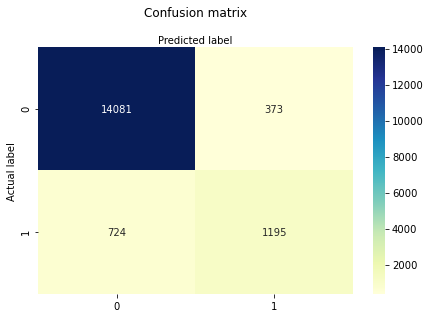

In [68]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, log_opt.predict(X_test))
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [69]:
# Classification report for the optimised Log Regression
log_opt.fit(X_train, y_train)
print(classification_report(y_test, log_opt.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     14454
           1       0.58      0.98      0.73      1919

    accuracy                           0.92     16373
   macro avg       0.79      0.94      0.84     16373
weighted avg       0.95      0.92      0.92     16373



In [73]:
log_opt.fit(X_train, y_train) 
probs = log_opt.predict_proba(X_test) 
# probabilities for labeled inefficient point
probs = probs[:, 1] 
logit_roc_auc = roc_auc_score(y_test, probs)
print('AUC score: '+ str(logit_roc_auc))

AUC score: 0.9657599501839151


In [74]:
rf_clf = RandomForestClassifier(class_weight = "balanced",random_state=random_state)
param_grid = {'n_estimators': [50, 75,100],
              'min_samples_split':[2,4,6],
              'min_samples_leaf': [1,2,3],
              'max_depth': [5,10,15]}

grid_obj = GridSearchCV(rf_clf,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=5)

grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print(str(grid_obj.best_estimator_))
print(grid_obj.best_score_)


RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=6, random_state=42)
0.8298273999652362


Text(0.5, 257.44, 'Predicted label')

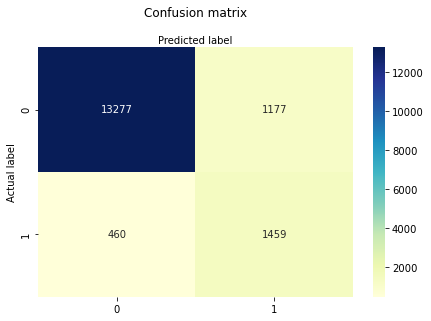

In [75]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, rf_opt.predict(X_test))
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [76]:
# Classification report for the optimised RF Regression
rf_opt.fit(X_train, y_train)
print(classification_report(y_test, rf_opt.predict(X_test)))


              precision    recall  f1-score   support

           0       0.97      0.92      0.94     14454
           1       0.55      0.76      0.64      1919

    accuracy                           0.90     16373
   macro avg       0.76      0.84      0.79     16373
weighted avg       0.92      0.90      0.91     16373



In [77]:
rf_opt.fit(X_train, y_train) 
probs = rf_opt.predict_proba(X_test) 
# probabilities for labeled inefficient point
probs = probs[:, 1]
rf_opt_roc_auc = roc_auc_score(y_test, probs)
print('AUC score: %.3f' % rf_opt_roc_auc)

AUC score: 0.879


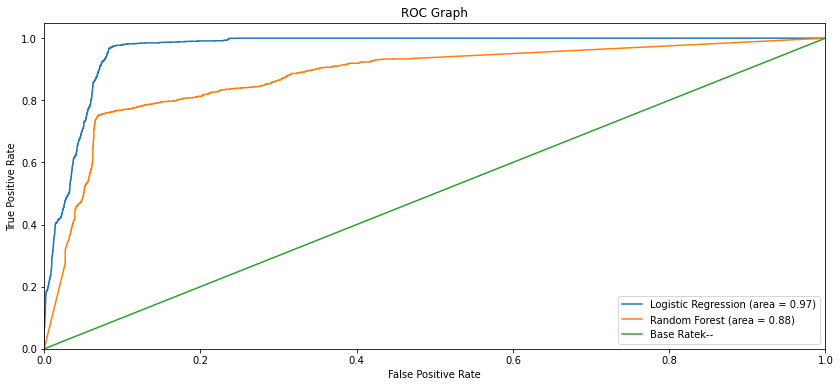

In [78]:
# Create ROC Graph

fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_opt.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_opt_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [ ]:

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

df_y_test = y_test.set_index('index').iloc[:,-1:]

X_train = X_train.set_index('index')
X_test = X_test.set_index('index')
y_train = y_train.set_index('index').iloc[:,-1]
y_test = y_test.set_index('index').iloc[:,-1]

random_state = 42

param_grid = {'C': np.arange(0.01, 2, 0.1)} # hyper-parameter list to fine-tune
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', # setting GridSearchCV
                                         class_weight="balanced",
                                         random_state=random_state),
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=5)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_


log_opt.fit(X_train, y_train)

labels = log_opt.predict(X_test)

X_test['efficient'] = labels
df_y_test_predict = X_test.iloc[:,-1:]


data = pd.read_csv('data.csv')
data_norm = pd.read_csv('data_norm.csv')

key_feature = ['supplyTemp-0', 'waterDiff-0', 'indoorTemp-0', 'outdoorTemp-0']


def plot(d,start_month):
    chart_st = alt.Chart(d).mark_line(color='red').encode(x='createTime:T', y='supplyTemp-0').properties(width=3000)
    chart_wd = alt.Chart(d).mark_line(color='blue').encode(x='createTime:T', y='waterDiff-0').properties(width=3000)
    chart_it = alt.Chart(d).mark_line(color='orange').encode(x='createTime:T', y='indoorTemp-0').properties(width=3000)
    chart_ot = alt.Chart(d).mark_line(color='green').encode(x='createTime:T', y='outdoorTemp-0').properties(width=3000)

    chart_eff = alt.Chart(d[d['efficient'] == 1]).mark_circle(size=60,color='red').encode(x='createTime:T', y='outdoorTemp-0').properties(width=3000)

    start = "2021-07-01 00:00:00"
    end = "2021-07-10 00:00:00"

    if (start_month == 8):
        start = "2021-08-01 00:00:00"
        end = "2021-08-10 00:00:00"
    elif (start_month == 9):
        start = "2021-09-01 00:00:00"
        end = "2021-09-10 00:00:00"

    source = [{
        "start": start,
        "end": end,
        "name": "train zone"
    }]

    chart_train_zone = alt.Chart(pd.DataFrame(source)).mark_rect(color='green',opacity=0.3).encode(x='start:T', x2='end:T', color = 'name:O').properties(width=3000)
    return chart_st + chart_wd + chart_it + chart_ot + chart_eff + chart_train_zone


df_y_train = pd.DataFrame(y_train)

df_y_test_predict.loc[:,'efficient'] = 0

data_labeled = pd.merge(data,pd.concat([df_y_test_predict,df_y_train]),how = 'left', left_index=True, right_index=True)
#data_labeled = pd.merge(data,pd.concat([df_y_test,df_y_train]),how = 'left', left_index=True, right_index=True)

data_labeled['createTime'] = pd.to_datetime(data_labeled['createTime'])
chart = alt.vconcat(plot(data_labeled.loc[(data_labeled['createTime'] >= dt.datetime(2021,7,1,0)) & (data_labeled['createTime'] < dt.datetime(2021,8,1,0))],7) ,\
                    plot(data_labeled.loc[(data_labeled['createTime'] >= dt.datetime(2021,8,1,0)) & (data_labeled['createTime'] < dt.datetime(2021,9,1,0))],8) ,\
                    plot(data_labeled.loc[(data_labeled['createTime'] >= dt.datetime(2021,9,1,0)) & (data_labeled['createTime'] < dt.datetime(2021,10,1,0))],9))

chart.save('modeled.html')
#chart.save('modeled_trained.html')